In [1]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [ ]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from data_retrieval import lipade_groundtruth
from data_retrieval.tools.data_loader import getDataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizerFunc = optim.Adam
temperature = 0.5
learningRate = 1e-3
batch_size = 64
workers = 2
corpus = "lipade_groundtruth"
resultsPath = "../results/distance/" + corpus + "/"

Dataset

In [3]:
x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

images = []
for i in range(len(x)):
    images.append(Image.open(x[i]).convert('RGB'))

In [4]:
x = np.array(x)
y = np.array(y)
images = np.array(images)

images.shape

(5917, 256, 256, 3)

In [5]:
trainLoader = getDataLoader(images, None, None, False, batch_size, True, num_workers=2)

Transformations

In [6]:
# Sepia or grayscale possibly flipped

class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super(transforms_SepiaFilter, self).__init__()

    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)

transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.Grayscale(num_output_channels=3),
        transforms_SepiaFilter()
    ]),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [7]:
# possible +/- 45 degrees rotations, possibly cropped

class transforms_Rotate(nn.Module):
    def __init__(self):
        super(transforms_Rotate, self).__init__()

    def __call__(self, batch):
        batch = batch.movedim(2,3)    
        return batch

transform2 = transforms.Compose([
    transforms.RandomApply([
        transforms_Rotate(),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(1),
            transforms.RandomVerticalFlip(1)
        ])], 2/3),
    transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5,1), ratio=(1,1))
])

In [8]:
transformRandom = transforms.RandomChoice([transform1, transform2])

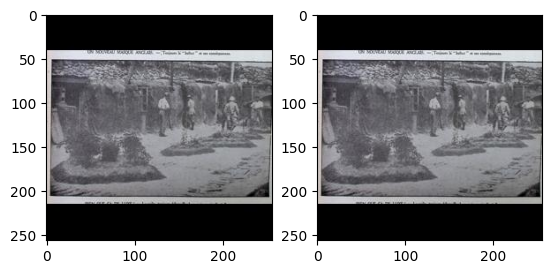

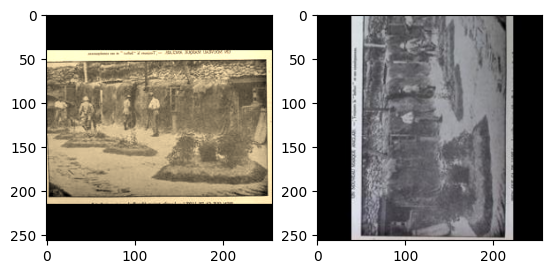

In [9]:
for batch in trainLoader:
    batch1 = transform1(batch)
    batch2 = transform2(batch)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch[0]))
    plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch1[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch2[0]))
    plt.show()
    break

Representation

In [10]:
class SimCLR_Representation(nn.Module):
    def __init__(self, encoder, in_dim=2048, out_dim=128):
        super(SimCLR_Representation, self).__init__()
        self.encoder = encoder
        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    
    def forward(self, x_):
        h = self.encoder(x_)
        z = self.projection(h)
        return z

In [11]:
# ResNet50 - Stage 4
representationEncoder = resnet18(weights=ResNet18_Weights.DEFAULT)
representationEncoder.fc = nn.Identity()

Loss

In [12]:
def infoNCEloss(z1, z2, t=1):
    z = torch.cat([z1, z2], dim=0)

    s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
    exp_s = torch.exp(s / t)
    indicatorMask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device) # True on diagonal, False elsewhere
    exp_s = exp_s.masked_fill(indicatorMask, 0)

    numerator = F.cosine_similarity(z1, z2, dim=-1)      # for z1
    numerator = torch.cat([numerator, numerator], dim=0) # for z2
    numerator = torch.exp(numerator / t)

    denominator = exp_s.sum(dim=1)

    l = -torch.log(numerator / denominator)
    return l.mean()

Train

In [13]:
torch.cuda.empty_cache()

In [14]:
model = SimCLR_Representation(representationEncoder, in_dim=512).to(device)
optimizer = optimizerFunc(model.parameters(), lr=learningRate)

In [15]:
lastBatch = images.shape[0] // batch_size

Epoch 0: 100%|██████████| 93/93 [00:28<00:00,  3.29it/s]


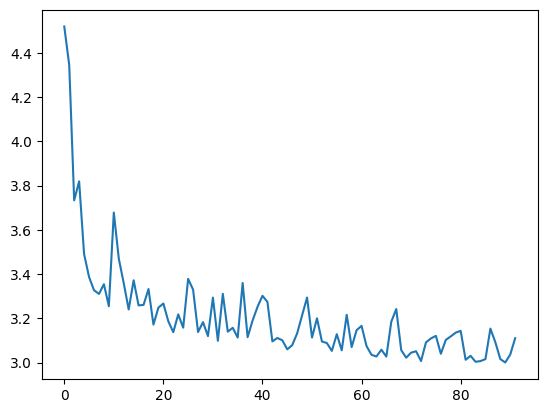

Epoch 10: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


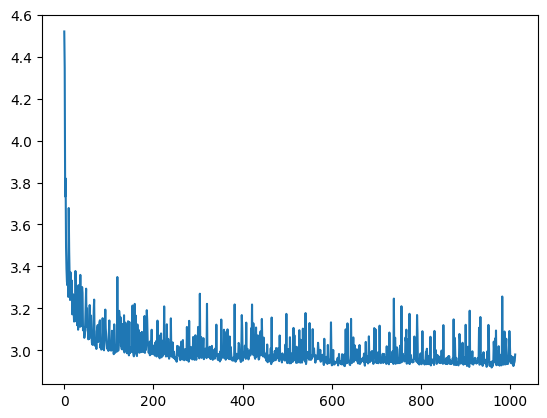

Epoch 20: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


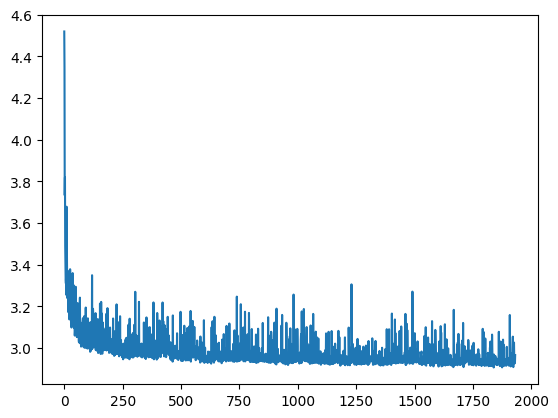

Epoch 30: 100%|██████████| 93/93 [00:28<00:00,  3.29it/s]


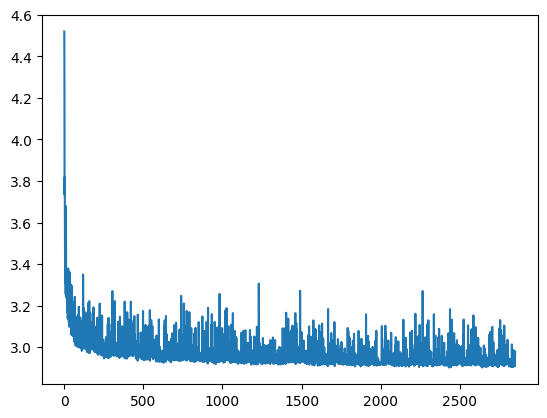

Epoch 40: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


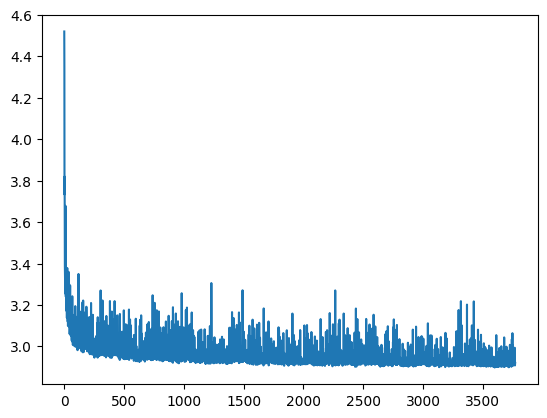

Epoch 50: 100%|██████████| 93/93 [00:28<00:00,  3.29it/s]


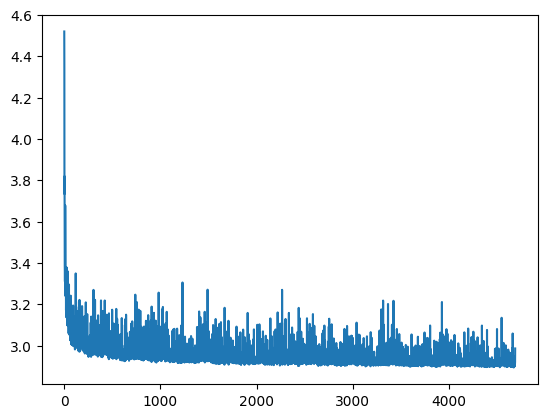

Epoch 60: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


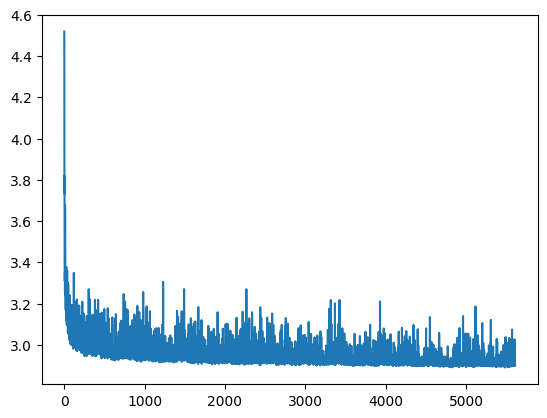

Epoch 70: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


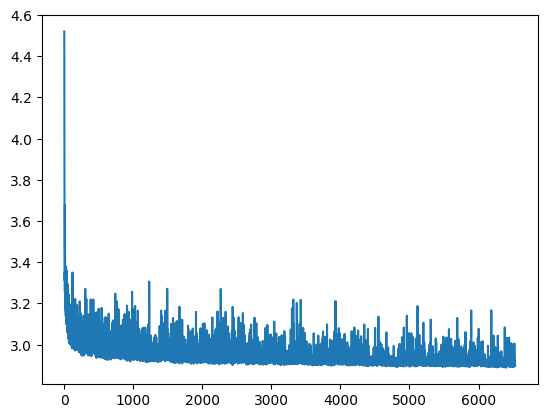

Epoch 80: 100%|██████████| 93/93 [00:28<00:00,  3.28it/s]


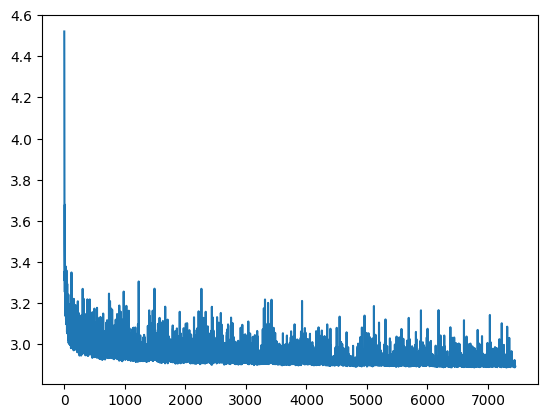

Epoch 90: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


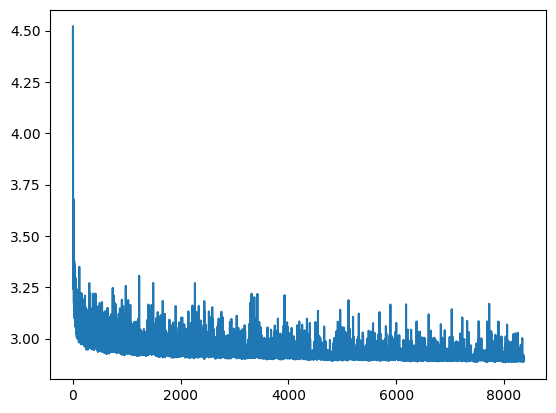

Epoch 100: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


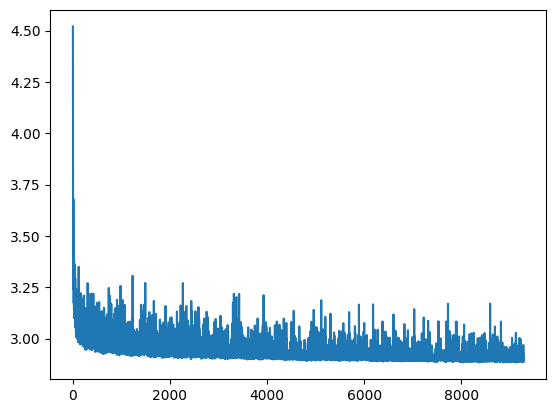

Epoch 110: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


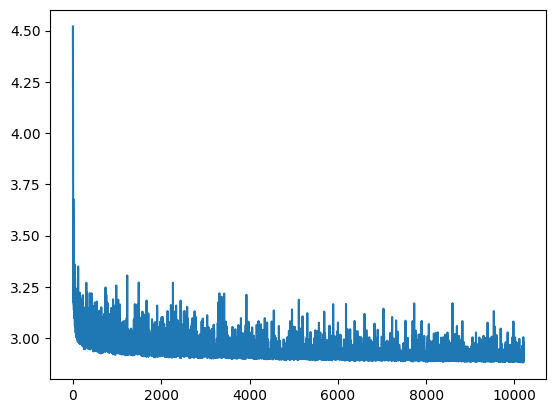

Epoch 120: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


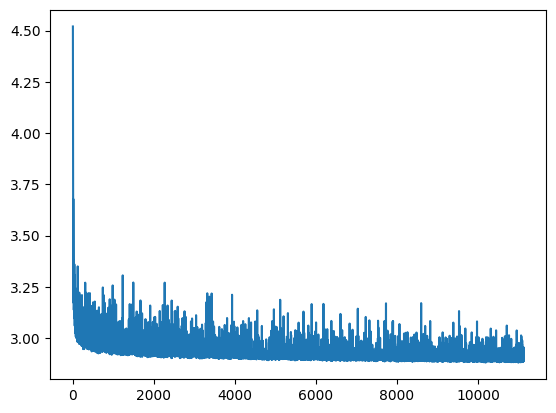

Epoch 130: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


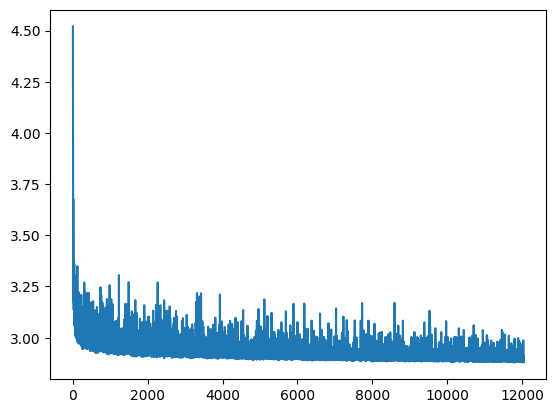

Epoch 140: 100%|██████████| 93/93 [00:28<00:00,  3.31it/s]


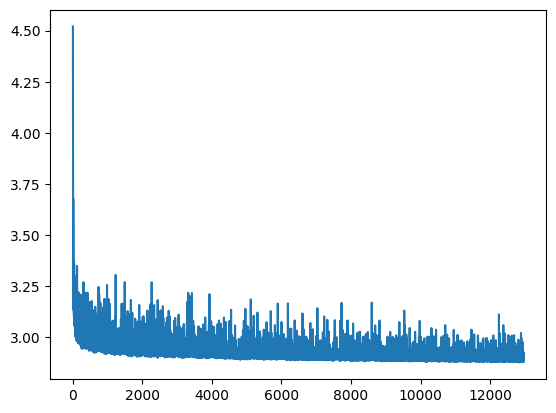

Epoch 150: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


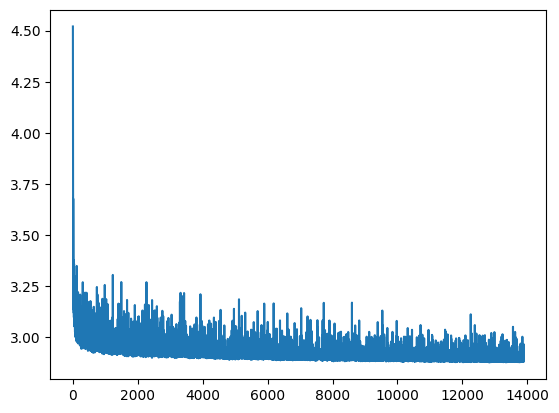

Epoch 160: 100%|██████████| 93/93 [00:28<00:00,  3.32it/s]


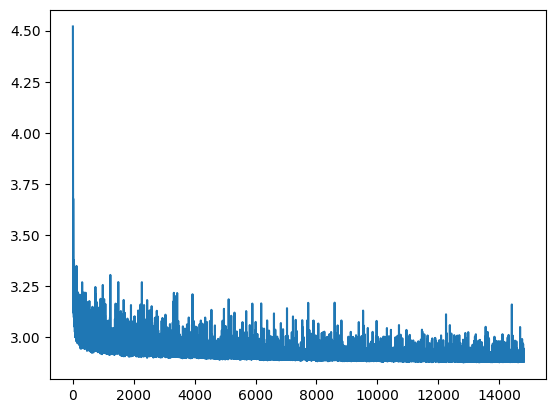

Epoch 170: 100%|██████████| 93/93 [00:28<00:00,  3.30it/s]


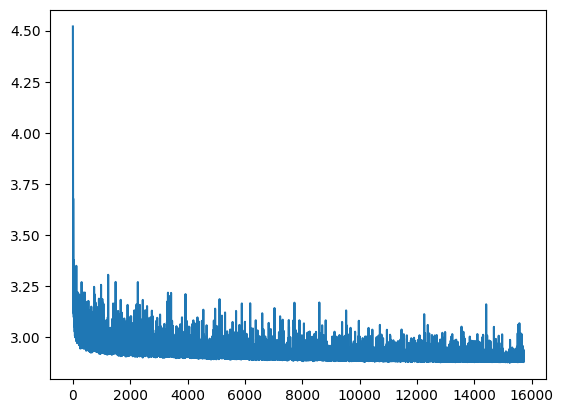

Epoch 180: 100%|██████████| 93/93 [00:28<00:00,  3.29it/s]


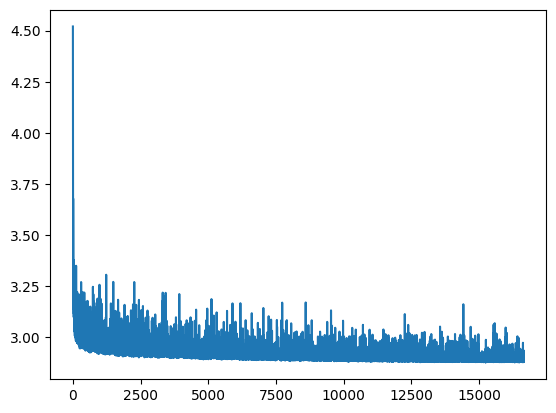

Epoch 190: 100%|██████████| 93/93 [00:28<00:00,  3.31it/s]


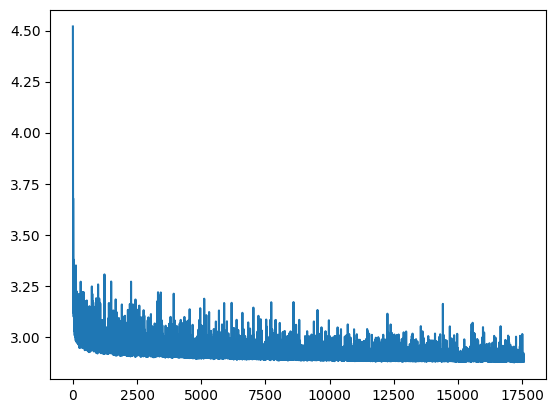

Epoch 199: 100%|██████████| 93/93 [00:28<00:00,  3.31it/s]


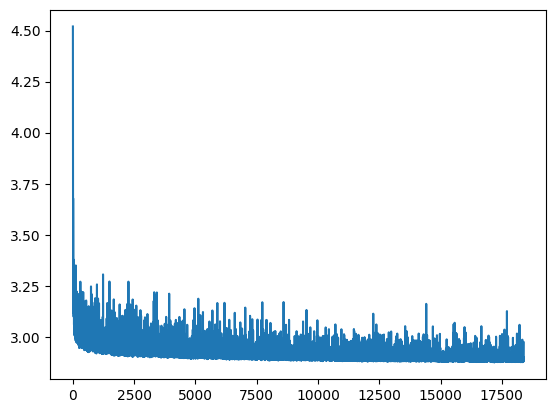

In [16]:
model.train()

epochs = 200
losses = []
for epoch in range(epochs):
    for i,sampledMinibatch in enumerate(tqdm(trainLoader, desc="Epoch " + str(epoch))):
        x = sampledMinibatch.to(device)
        # Transformation
        x_2 = transformRandom(x)
        # Representation
        z1 = model(x)
        z2 = model(x_2)
        # Loss
        loss = infoNCEloss(z1, z2, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i != lastBatch:
            losses.append(loss.item())
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.show()
plt.plot(losses)
plt.show()

In [17]:
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)

imagesSim = []
for i in range(len(xSim)):
    imagesSim.append(Image.open(xSim[i]).convert('RGB'))

In [18]:
testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)

In [19]:
representations = []
with torch.no_grad():
    for batch in testLoader:
        batch = model(batch.to(device))
        for repr in batch.tolist():
            representations.append(repr)

In [20]:
sim = cosine_similarity(representations, representations)

distance = 1 - (sim+1)/2
distance -= np.diag(distance)

In [21]:
np.save(resultsPath + "simclr.npy", distance)